# Credit Risk EDA and Preliminary Analysis

By Jonathan Ling, Hanson Qin, Duncan Black, and Fernando Machado

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats.stats import pearsonr
import itertools
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from sklearn import preprocessing
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

## Data Loading and Cleaning

We are interested in predicting whether a credit loan would be charged off given other attributes of the loan.

For data cleaning, we start with only considering loans that are either fully paid or charged off, since we do not know the future state of a loan in the process of being paid off or charged off. 

We notice that many columns are dense with missing values. We choose to drop all columns that consists of more than 90% missing values, and we further choose to drop all rows containing missing values, which is around 20% of all observations. We then would drop all the columns that satisfy at least one of the following criteria:
    - Contains post-charge-off information
    - Obviously does not relate to charge off information (like ID)
    - Categorical column containing many categories (greater than 50)

We then normalize the numeric columns and apply One Hot Encoding (OHE) to the categorical columns, dropping one of each OHE columns to prevent multicollinearity.

In [2]:
data = pd.read_csv("accepted_2007_to_2018Q4.csv.gz")

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Comparison Metric
data[['grade','sub_grade']].head(20)

,grade,sub_grade
0,C,C4
1,C,C1
2,B,B4
3,C,C5
4,F,F1
5,C,C3
6,B,B2
7,B,B1
8,A,A2
9,B,B5


In [4]:
pd.options.display.max_rows = 410
pd.options.display.max_columns = 40

In [5]:
#Function for cleaning the data
#Inputs:
#    df: a pandas dataframe
# Output: a pandas dataframe

def CleanData(data):
    
    #Valid responses
    data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]

    
    #Drop column if more than alpha are non-Null
    alpha = 0.90

    data_cleaned = data.dropna(axis='columns',thresh = np.ceil(alpha*len(data)))
    data_cleaned = data_cleaned.dropna()

    #Split into numeric and nonnumeric
    numeric = data_cleaned[data_cleaned.columns[np.where(data_cleaned[data_cleaned.columns].dtypes=='float64')]]
    nonnumeric = data_cleaned[data_cleaned.columns[np.where(data_cleaned[data_cleaned.columns].dtypes!='float64')]]

    #Drop columns we dont want
    nndrops = ["id","grade","sub_grade","emp_title","loan_status","zip_code","addr_state",
               "title","pymnt_plan","url","hardship_flag","issue_d","last_pymnt_d","earliest_cr_line",
              "last_credit_pull_d","debt_settlement_flag", 'disbursement_method']
    ndrops = ["installment","int_rate","last_pymnt_amnt","out_prncp","out_prncp_inv",
 "total_pymnt","total_pymnt_inv","total_rec_int","total_rec_late_fee","total_rec_prncp",
              'out_prncp', 'out_prncp_inv', 'policy_code',"recoveries","collection_recovery_fee",
             'funded_amnt','funded_amnt_inv',"last_pymnt_amnt",'last_fico_range_low']
    high_corr = ['fico_range_high',
             'num_sats',
             'num_rev_tl_bal_gt_0',
             'tot_hi_cred_lim',
             'total_il_high_credit_limit',
             'bc_util',
             'bc_open_to_buy',
             'avg_cur_bal',
             'num_rev_accts',
             'num_bc_sats',
             'last_fico_range_high',
             'num_op_rev_tl',
             'num_actv_bc_tl',
             'total_rev_hi_lim',
             'num_tl_30dpd',
             'num_tl_op_past_12m',
             'percent_bc_gt_75',
             'tax_liens',
             'total_acc',
             'num_actv_rev_tl',
             'num_tl_90g_dpd_24m',
             'pub_rec_bankruptcies',
             'mo_sin_rcnt_rev_tl_op'
             ]
    numeric = numeric.drop(ndrops,axis = 1)
    numeric = numeric.drop(high_corr,axis = 1)
    nonnumeric = nonnumeric.drop(nndrops,axis = 1)
    
    #Normalize numeric
    numeric=(numeric-numeric.mean())/numeric.std()

    #Categorical 
    def ohe_columns(df, columns):
        """
        :param df: input data in the form of a dataframe
        :param columns: list of columns to encode
        :return: df: dataframe with the encoded columns
        """
        for col in columns:
            df = pd.concat([df.drop([col], axis=1),
                            pd.get_dummies(df[col],
                            drop_first=True, prefix=col)], axis=1)
        return df

    nonnumeric = ohe_columns(nonnumeric,nonnumeric.columns)
    

    #Response Variable
    response=ohe_columns(data_cleaned[["loan_status"]],["loan_status"])
    new_cols = ['loan_status']
    response.columns = new_cols
    response = (response - 1)/255
    
    #Rename Problimatic Column
    nonnumeric = nonnumeric.rename(columns={"emp_length_< 1 year":"emp_length_lessthan 1 year"})

    #Concat
    output = pd.concat([numeric,nonnumeric,response],axis=1)
    return(output) 

#Function for cleaning the data
#Inputs:
#    data: a pandas dataframe
#    vprop/tprop: proportion of the data to be allocated to the validation/test sets, between 0 and 1
#    seed: an integer to set the randomization seed
# Output: a list of pandas dataframes for the training, validation, and test sets

def DataSplit(data,vprop,tprop,seed=None):
    
    #Split proportions
    p1 = tprop+vprop
    p2 = tprop/p1
    
    #Calling split functions
    y = data["loan_status"]
    X = data.drop(columns=["loan_status"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p1,random_state=seed)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=p2,random_state=seed)

    #Returning DataFrames
    data_train = pd.concat([X_train,y_train],axis=1)
    data_valid = pd.concat([X_valid,y_valid],axis=1)
    data_test = pd.concat([X_test,y_test],axis=1)
    return([data_train,data_valid,data_test])

In [6]:
cleaned_data = CleanData(data)

In [7]:
cleaned_data.head(5)

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,acc_open_past_24mths,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,...,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App,loan_status
0,-1.279805,-0.328290,-1.324187,-0.367941,-0.665734,0.418411,-0.896633,-0.348934,-0.630600,-0.912306,-0.117495,-0.067688,0.039362,-0.006856,-0.234697,-0.083813,-0.01913,0.430734,-0.548096,-0.578158,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
1,1.128247,-0.189792,-0.260252,0.756340,0.602387,3.734176,1.830556,-0.348934,0.232752,-1.345038,-0.117495,-0.067688,-0.021186,0.371173,-0.234697,-0.083813,-0.01913,-0.242290,0.166085,-0.700409,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.0
4,-0.503750,0.356344,0.715633,0.756340,-0.031674,2.628921,0.012430,-0.348934,0.253937,0.521891,-0.117495,-0.067688,-0.021186,1.180290,1.644573,-0.083813,-0.01913,0.046149,0.366949,-0.455907,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.0
5,-0.326855,-0.619134,-0.874504,-0.367941,-0.190189,-0.686844,-1.260258,-0.348934,-0.351032,0.682620,-0.117495,-0.067688,-0.021186,-0.846295,-1.487544,-0.083813,-0.01913,4.084291,-1.373869,2.967117,...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
6,0.591857,1.402928,-0.405953,-0.367941,-0.507219,-0.686844,0.012430,-0.348934,3.272551,1.346143,-0.117495,-0.067688,-0.021186,1.362200,0.391727,-0.083813,-0.01913,0.315358,1.438221,0.277598,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [8]:
# Checking default rate for each home ownership category
mort_def = sum(cleaned_data.loc[cleaned_data['home_ownership_MORTGAGE'] == 1]['loan_status'])
rent_def = sum(cleaned_data.loc[cleaned_data['home_ownership_RENT'] == 1]['loan_status'])
own_def = sum(cleaned_data.loc[cleaned_data['home_ownership_OWN'] == 1]['loan_status'])
none_def = sum(cleaned_data.loc[cleaned_data['home_ownership_NONE'] == 1]['loan_status'])
other_def = sum(cleaned_data.loc[cleaned_data['home_ownership_OTHER'] == 1]['loan_status'])

In [9]:
print("Default rate for home ownership = MORTGAGE:", 
      mort_def/cleaned_data.loc[cleaned_data['home_ownership_MORTGAGE'] == 1].shape[0])
print("Default rate for home ownership = RENT:", 
      rent_def/cleaned_data.loc[cleaned_data['home_ownership_RENT'] == 1].shape[0])
print("Default rate for home ownership = OWN:", 
      own_def/cleaned_data.loc[cleaned_data['home_ownership_OWN'] == 1].shape[0])

Default rate for home ownership = MORTGAGE: 0.16574626838522852
Default rate for home ownership = RENT: 0.22644589879058816
Default rate for home ownership = OWN: 0.19495008807985909


# Correlation Analysis

We start by running a simple correlation analysis. We compute the pairwise correlation of all our predictor variables to identify columns that have very high correlation. We notice that there are 10 pairs of predictors with a correlation of greater than 0.9, so we choose to drop a column from each pair.

Additionally, we compute the correlation of each predictor to our response variable to get an idea of which predictors correlate to the charge off rate.

Note: This takes a while, so we have already removed the highly correlated columns in the data cleaning function.

In [10]:
# List of names
names_list = cleaned_data.columns[0:len(cleaned_data.columns) - 1]

In [11]:
# Checking pairwise correlations
'''
correlations = {}

for col_a, col_b in itertools.combinations(names_list, 2):
    correlations[col_a + '__' + col_b] = pearsonr(cleaned_data.loc[:, col_a], cleaned_data.loc[:, col_b])

corr_result = pd.DataFrame.from_dict(correlations, orient='index')
corr_result.columns = ['PCC', 'p-value']
'''

"\ncorrelations = {}\n\nfor col_a, col_b in itertools.combinations(names_list, 2):\n    correlations[col_a + '__' + col_b] = pearsonr(cleaned_data.loc[:, col_a], cleaned_data.loc[:, col_b])\n\ncorr_result = pd.DataFrame.from_dict(correlations, orient='index')\ncorr_result.columns = ['PCC', 'p-value']\n"

In [12]:
#print(corr_result.sort_values('PCC', ascending=False).head(30))

In [13]:
# High Correlation variables (>0.6):
# We manually choose 0.6 here, but 
'''
high_corr = ['fico_range_high',
             'funded_amnt',
             'total_pymnt_inv',
             'funded_amnt_inv',
             'num_sats',
             'num_rev_tl_bal_gt_0',
             'tot_hi_cred_lim',
             'total_rec_prncp',
             'installment',
             'total_il_high_credit_limit',
             'bc_util',
             'total_pymnt',
             'bc_open_to_buy',
             'avg_cur_bal',
             'num_rev_accts',
             'num_bc_sats',
             'last_fico_range_high',
             'num_op_rev_tl',
             'num_actv_bc_tl',
             'total_rev_hi_lim',
             'num_tl_30dpd',
             'num_tl_op_past_12m',
             'percent_bc_gt_75',
             'tax_liens',
             'total_acc',
             'num_actv_rev_tl',
             'num_tl_90g_dpd_24m',
             'pub_rec_bankruptcies',
             'total_rec_int',
             'mo_sin_rcnt_rev_tl_op'
             ]
cleaned_data = cleaned_data.drop(high_corr,axis=1)
'''

"\nhigh_corr = ['fico_range_high',\n             'funded_amnt',\n             'total_pymnt_inv',\n             'funded_amnt_inv',\n             'num_sats',\n             'num_rev_tl_bal_gt_0',\n             'tot_hi_cred_lim',\n             'total_rec_prncp',\n             'installment',\n             'total_il_high_credit_limit',\n             'bc_util',\n             'total_pymnt',\n             'bc_open_to_buy',\n             'avg_cur_bal',\n             'num_rev_accts',\n             'num_bc_sats',\n             'last_fico_range_high',\n             'num_op_rev_tl',\n             'num_actv_bc_tl',\n             'total_rev_hi_lim',\n             'num_tl_30dpd',\n             'num_tl_op_past_12m',\n             'percent_bc_gt_75',\n             'tax_liens',\n             'total_acc',\n             'num_actv_rev_tl',\n             'num_tl_90g_dpd_24m',\n             'pub_rec_bankruptcies',\n             'total_rec_int',\n             'mo_sin_rcnt_rev_tl_op'\n             ]\ncleaned_dat

In [14]:
# Update list of names
#names_list = cleaned_data.columns[0:len(cleaned_data.columns) - 1]

In [15]:
# Checking pairwise X-y correlations
'''
correlations_y = {}

for col_x in names_list:
    correlations_y[col_x] = pearsonr(cleaned_data.loc[:, col_x], cleaned_data.loc[:, 'loan_status'])

corr_y_result = pd.DataFrame.from_dict(correlations_y, orient='index')
corr_y_result.columns = ['PCC', 'p-value']

print(corr_y_result.sort_values('PCC', ascending=False).head(20))
'''
# All variables are < 0.30 correlation with the response variable, so we will not drop any

"\ncorrelations_y = {}\n\nfor col_x in names_list:\n    correlations_y[col_x] = pearsonr(cleaned_data.loc[:, col_x], cleaned_data.loc[:, 'loan_status'])\n\ncorr_y_result = pd.DataFrame.from_dict(correlations_y, orient='index')\ncorr_y_result.columns = ['PCC', 'p-value']\n\nprint(corr_y_result.sort_values('PCC', ascending=False).head(20))\n"

# Regression Analysis

We start our regression analysis by fitting all of our predictors to the response variable through individual logistic regression models. Afterwards, we take the top 20 fields with the highest t-statistic and run a multivariate logistic regression model on those fields.

In [16]:
# Write a function to perform the logistic regression
# Inputs: 
#    X: 2D array
#    y: Charged Off variable (1d array)
# Output: [coefficient, t-value]

def regress_log(X, y):
    
    log_reg = sm.Logit(np.asarray(y), X).fit(disp=0)
    
    return [log_reg.params, log_reg.t_test('x1=0').tvalue]


In [17]:
# Define y as the dummy variable for charged off loans
# Note: may need to change this depending on the data format
y = cleaned_data['loan_status']

# Initialize results dataframe
reg_results = pd.DataFrame(np.zeros((len(names_list), 3)))
reg_results[0] = names_list
reg_results = reg_results.set_axis(['name','coef','t-stat'], axis = 1)

In [18]:
# Loop the regression over all variable names
for i in range(len(names_list)):
    X = np.array(cleaned_data[names_list[i]]).reshape(-1,1)
    results = regress_log(X, y)
    
    reg_results['coef'][i] = results[0][0]
    reg_results['t-stat'][i] = np.abs(results[1][0])

<ipython-input-18-76259713fd88>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_results['coef'][i] = results[0][0]
<ipython-input-18-76259713fd88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_results['t-stat'][i] = np.abs(results[1][0])
/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [19]:
reg_results.head()

,name,coef,t-stat
0,loan_amnt,0.110398,57.398047
1,annual_inc,-0.099244,36.152158
2,dti,0.182704,84.581677
3,delinq_2yrs,0.029809,15.464332
4,fico_range_low,-0.211274,107.559761


# Example: Regress Loan Status against Open Accounts

In [20]:
X_examp = np.array(cleaned_data['open_acc']).reshape(-1,1)

In [21]:
results_examp = sm.Logit(np.asarray(y), add_constant(X_examp)).fit(disp=0)

In [22]:
results_examp.params

array([-1.43529483,  0.08118468])

In [23]:
def f(x):
   return np.exp(results_examp.params[0] + results_examp.params[1] * x) / (1 + np.exp(results_examp.params[0] + results_examp.params[1] * x))
x = np.linspace(-3, 15, 100)

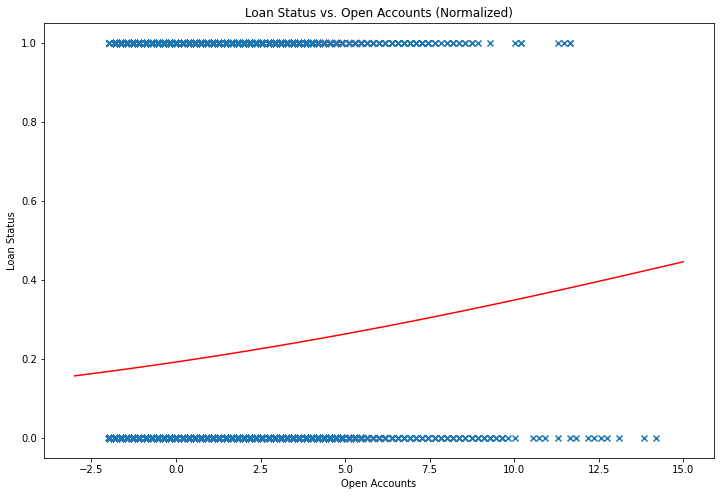

In [24]:
# Graph with the fitted logistic curve
ax = plt.figure(figsize=(12,8))
ax = plt.scatter(X_examp, y, marker = 'x')
ax = plt.plot(x, f(x), color='red')
ax = plt.title("Loan Status vs. Open Accounts (Normalized)")
ax = plt.xlabel("Open Accounts")
ax = plt.ylabel("Loan Status")

In [25]:
# Order the results by t-statistic
sorted_results = reg_results.sort_values(by = 't-stat', axis = 0, ascending = False)

top20 = sorted_results.head(25)
top20

,name,coef,t-stat
60,initial_list_status_w,-1.436911,462.637417
40,home_ownership_MORTGAGE,-1.616079,445.575222
48,purpose_debt_consolidation,-1.361432,439.638668
45,verification_status_Source Verified,-1.346696,367.325234
30,emp_length_10+ years,-1.491798,358.606594
44,home_ownership_RENT,-1.228490,336.428640
47,purpose_credit_card,-1.646585,297.931696
46,verification_status_Verified,-1.210967,281.397102
43,home_ownership_OWN,-1.418161,188.355308
29,term_ 60 months,-0.761902,185.719799


In [26]:
# Fit a multiple logistic regression using top 20 covariates
top20_names = top20['name']

X_multiple = cleaned_data[top20_names]
X_multiple.head()


,initial_list_status_w,home_ownership_MORTGAGE,purpose_debt_consolidation,verification_status_Source Verified,emp_length_10+ years,home_ownership_RENT,purpose_credit_card,verification_status_Verified,home_ownership_OWN,term_ 60 months,emp_length_2 years,emp_length_3 years,emp_length_lessthan 1 year,purpose_home_improvement,emp_length_5 years,emp_length_4 years,purpose_other,emp_length_6 years,emp_length_8 years,emp_length_7 years,emp_length_9 years,fico_range_low,purpose_major_purchase,dti,acc_open_past_24mths
0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.665734,0,-1.324187,-0.234697
1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.602387,0,-0.260252,-0.234697
4,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,-0.031674,1,0.715633,1.644573
5,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.190189,0,-0.874504,-1.487544
6,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.507219,0,-0.405953,0.391727


In [27]:
log_reg_mult = sm.Logit(np.asarray(y), X_multiple).fit()
print(log_reg_mult.summary())

Optimization terminated successfully.
         Current function value: 0.452794
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              1090611
Model:                          Logit   Df Residuals:                  1090586
Method:                           MLE   Df Model:                           24
Date:                Tue, 22 Mar 2022   Pseudo R-squ.:                 0.07585
Time:                        16:28:59   Log-Likelihood:            -4.9382e+05
converged:                       True   LL-Null:                   -5.3435e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
initial_list_status_w                  -0.0406      0.005 

In [28]:
cov = log_reg_mult.cov_params()
std_err = np.sqrt(np.diag(cov))
z = np.abs(log_reg_mult.params / std_err)
z=z.sort_values(ascending=True)
coefs = log_reg_mult.params.sort_values(ascending=True)
#[log_reg.params, log_reg.t_test('x1=0').tvalue]

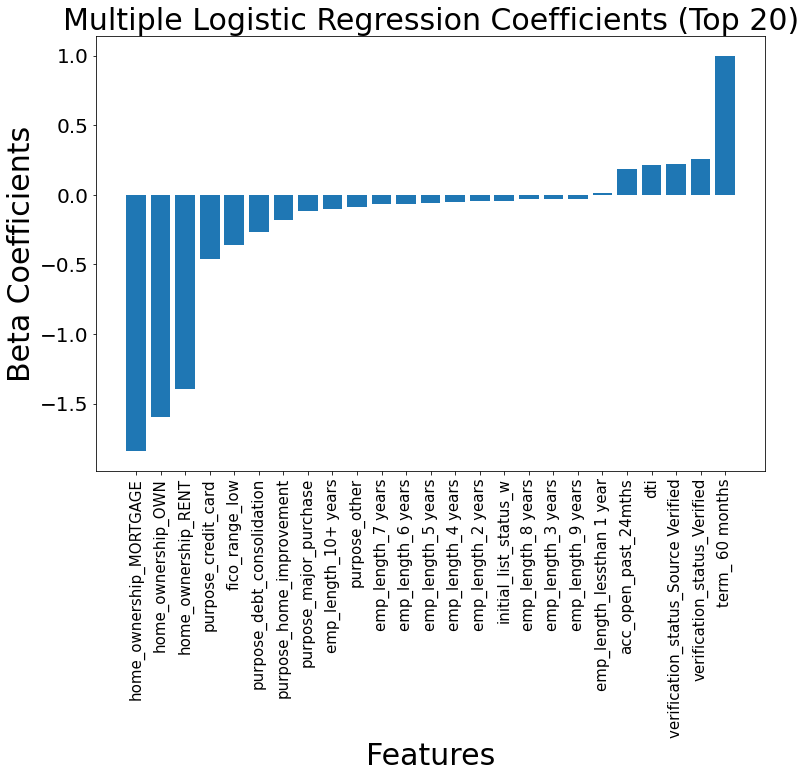

In [29]:
#Plotting the beta coefficients
params = {'axes.labelsize': 30,'axes.titlesize':30, 'font.size': 60, 'xtick.labelsize': 15, 'ytick.labelsize': 20}
ax = plt.rcParams.update(params)
ax = plt.figure(figsize=(12,8))
ax = plt.bar(x=np.array(coefs.index), height = coefs)
ax = plt.xticks(rotation=90)
ax = plt.xlabel("Features")
ax = plt.ylabel('Beta Coefficients')
ax = plt.title("Multiple Logistic Regression Coefficients (Top 20)")

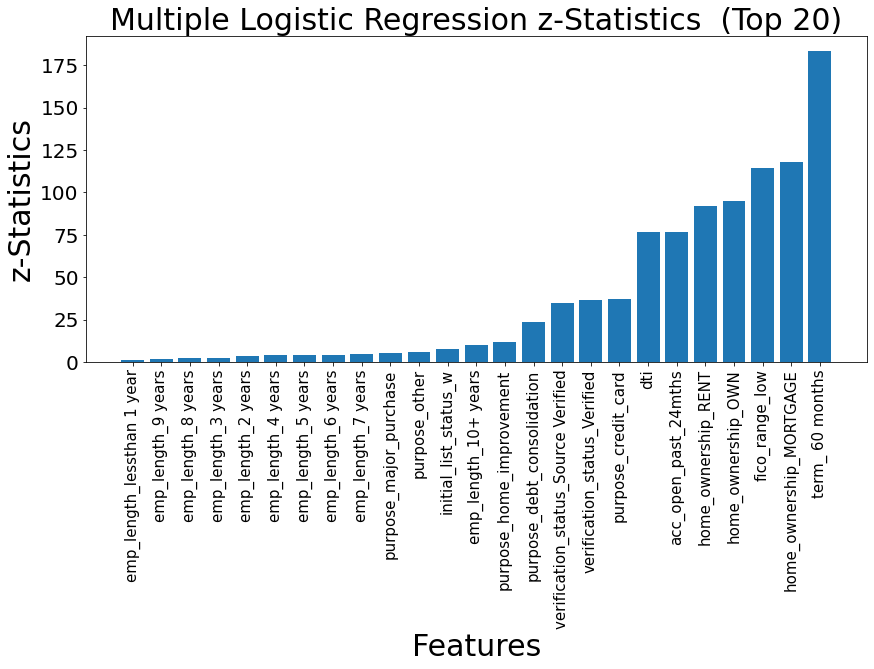

In [30]:
#Plotting the z statistics
params = {'axes.labelsize': 30,'axes.titlesize':30, 'font.size': 60, 'xtick.labelsize': 15, 'ytick.labelsize': 20}
ax = plt.rcParams.update(params)
ax = plt.figure(figsize=(14,6))
ax = plt.bar(x=np.array(z.index), height = z)
ax = plt.xticks(rotation=90)
ax = plt.xlabel("Features")
ax = plt.ylabel('z-Statistics')
ax = plt.title("Multiple Logistic Regression z-Statistics  (Top 20)")

Next, we will use training/validation/test sets to select the optimal number of variables to use for prediction using logistic regression.

# Splitting the Data

In [31]:
cleaned_data=CleanData(data)

In [32]:
splitdata=DataSplit(cleaned_data,0.1,0.1,seed=0)

In [33]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [34]:
# Used when fitting parameters
# Cutting down training data size
trainingdata = trainingdata.sample(frac=0.05, replace=False, random_state=1)
trainingdata
validationdata =  validationdata.sample(frac=1, replace=False, random_state=1)
validationdata
testdata =  testdata.sample(frac=1, replace=False, random_state=1)
testdata

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,acc_open_past_24mths,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,...,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App,loan_status
295564,1.504862,1.541425,-1.220414,-0.367941,-0.507219,-0.686844,0.194243,-0.348934,-0.131098,1.387355,-0.117495,-0.067688,-0.021186,-0.372799,0.078515,-0.083813,-0.01913,0.603797,-0.224483,-0.822660,...,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
2254637,-0.549400,-0.536036,-1.017061,0.756340,-1.141280,0.418411,-0.533008,-0.348934,-0.508701,0.138614,-0.117495,-0.067688,0.032737,-0.893266,1.018150,-0.083813,-0.01913,0.353817,0.288835,-0.822660,...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0
286921,1.048359,0.294948,-1.049555,-0.367941,-0.190189,-0.686844,0.194243,-0.348934,0.576984,0.830986,-0.117495,-0.067688,-0.021186,2.196048,-0.861120,-0.083813,-0.01913,-0.126914,-0.737801,0.155347,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
266622,0.591857,0.257554,1.195714,-0.367941,0.443872,-0.686844,1.103306,-0.348934,1.073625,-0.219935,-0.117495,-0.067688,-0.021186,0.011057,1.331362,-0.083813,-0.01913,0.526880,0.043335,-0.578158,...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
1845013,-0.971665,-0.674533,-0.027549,-0.367941,-0.507219,0.418411,-0.533008,-0.348934,-0.137421,0.476558,-0.117495,-0.067688,-0.021186,-0.782339,0.391727,-0.083813,-0.01913,0.026920,0.099131,-0.455907,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794455,1.504862,0.348034,-0.287505,-0.367941,1.077932,3.734176,-1.078446,-0.348934,0.170164,0.876319,-0.117495,-0.067688,-0.021186,-0.518223,-1.487544,-0.083813,-0.01913,0.219212,0.735198,2.111361,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0
146272,-1.054406,-0.691153,-1.454165,0.756340,-0.507219,-0.686844,-1.442071,-0.348934,-0.658339,0.835107,-0.117495,-0.067688,-0.021186,-0.911744,-0.547908,-0.083813,-0.01913,0.084607,-1.730960,0.888852,...,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
1035,0.860052,0.087202,1.807870,-0.367941,0.602387,0.418411,0.012430,-0.348934,0.870999,0.802137,-0.117495,-0.067688,-0.021186,0.080725,-0.861120,-0.083813,-0.01913,-0.549958,-0.436506,1.744608,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0
999466,-0.595051,0.294948,-1.249764,8.626308,0.126841,-0.686844,0.921493,-0.348934,-0.322092,0.666135,-0.117495,-0.067688,-0.021186,0.823770,-1.487544,-0.083813,-0.01913,1.334508,0.132608,6.634643,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0


,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,acc_open_past_24mths,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,...,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App,loan_status
1833090,1.162485,0.274174,0.740790,1.880621,-1.141280,-0.686844,0.194243,-0.348934,0.129362,2.013787,-0.117495,-0.067688,-0.021186,1.380895,0.078515,-0.083813,-0.01913,0.353817,1.270835,-0.700409,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1822784,-1.319749,-0.882279,-0.224613,0.756340,-0.507219,-0.686844,-0.533008,-0.348934,-0.557904,-0.644424,-0.117495,-0.067688,-0.021186,-0.888748,-1.174332,-0.083813,-0.01913,0.949924,0.556653,1.744608,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
132362,0.705982,0.294948,-0.186877,-0.367941,1.077932,-0.686844,0.376055,-0.348934,0.039496,1.572812,-0.117495,-0.067688,-0.021186,-0.705910,-1.487544,-0.083813,-0.01913,0.315358,0.043335,3.333869,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1819717,-1.393930,-0.304679,0.434712,-0.367941,-0.665734,-0.686844,0.739680,-0.348934,0.649126,1.453296,-0.117495,-0.067688,-0.021186,-0.722965,0.078515,-0.083813,-0.01913,0.757631,0.221880,-0.822660,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0
719741,1.048359,1.818420,0.812069,-0.367941,-0.507219,-0.686844,0.739680,-0.348934,3.234380,1.914876,-0.117495,-0.067688,-0.021186,1.584823,1.018150,-0.083813,-0.01913,0.565339,0.433903,-0.333657,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281522,-0.092897,0.474995,-0.740333,-0.367941,-0.824249,0.418411,0.557868,1.295390,-0.258535,0.427102,-0.117495,-0.067688,-0.021186,1.787632,1.644573,-0.083813,-0.01913,0.084607,-0.280278,-0.578158,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
86352,-0.549400,-0.189792,-0.755008,-0.367941,-0.507219,-0.686844,-0.896633,1.295390,-0.662217,-0.133389,-0.117495,-0.067688,-0.008019,-0.817834,-1.174332,-0.083813,-0.01913,0.603797,0.043335,1.989110,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0
531468,-0.891777,-0.259041,-0.673247,-0.367941,-0.507219,0.418411,0.194243,1.295390,-0.464853,-0.458968,-0.117495,-0.067688,-0.021186,0.763093,0.704938,-0.083813,-0.01913,0.026920,0.054494,-0.455907,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0
1322290,0.591857,-0.148243,-1.107207,-0.367941,2.346053,3.734176,0.194243,-0.348934,0.105822,-1.332674,-0.117495,-0.067688,-0.021186,-0.329850,1.018150,-0.083813,-0.01913,0.007690,0.322312,-0.578158,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0


,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,acc_open_past_24mths,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,...,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App,loan_status
1839944,-1.279805,0.294948,0.130731,-0.367941,0.126841,-0.686844,-0.714820,1.295390,-0.505932,1.127716,-0.117495,-0.067688,-0.021186,-0.684407,-0.547908,-0.083813,-0.01913,0.546109,1.772993,0.277598,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
177578,0.703129,-0.224195,0.479786,-0.367941,-0.507219,1.523666,0.376055,6.228362,0.391160,0.620802,-0.117495,-0.067688,-0.021186,-0.132556,1.644573,-0.083813,-0.01913,0.430734,0.255358,-0.333657,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
660842,-0.549400,-0.549886,0.640162,-0.367941,-0.665734,-0.686844,0.921493,-0.348934,-0.209886,-0.186965,-0.117495,-0.067688,-0.021186,-0.488663,2.270997,-0.083813,-0.01913,-0.126914,-0.603892,-0.089155,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
1820317,2.303742,1.402928,-1.342006,0.756340,-0.982764,-0.686844,-1.260258,-0.348934,-0.411404,0.093281,-0.117495,-0.067688,-0.021186,-0.879871,-0.861120,-0.083813,-0.01913,0.296129,-0.536937,0.277598,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0
1488397,-1.234154,0.502695,0.425279,-0.367941,1.553477,-0.686844,2.012369,-0.348934,-0.472053,-1.711830,-0.117495,-0.067688,-0.021186,2.128737,2.584208,-0.083813,-0.01913,0.411505,-0.536937,-0.333657,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291819,0.021228,-0.293666,-1.497142,-0.367941,-1.141280,0.418411,-0.714820,-0.348934,-0.490054,-0.388907,-0.117495,-0.067688,0.020913,-0.188379,0.704938,-0.083813,-0.01913,-2.088297,-0.715483,-0.333657,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
230542,-0.549400,0.433446,-1.009723,-0.367941,1.870508,0.418411,0.012430,-0.348934,0.202612,-1.011216,-0.117495,-0.067688,-0.021186,-0.252862,-0.547908,-0.083813,-0.01913,0.276900,1.471698,-0.211406,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
289632,0.135354,-0.386459,0.996554,0.756340,-1.141280,0.418411,0.921493,-0.348934,-0.233010,-0.360058,-0.117495,-0.067688,-0.021186,-0.278260,1.331362,-0.083813,-0.01913,-0.992230,-1.050255,0.277598,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
36380,-1.051553,-0.342140,1.622336,-0.367941,-0.507219,0.418411,-0.714820,-0.348934,0.187334,1.791239,-0.117495,-0.067688,-0.021186,0.592163,-0.861120,-0.083813,-0.01913,0.546109,1.549812,0.277598,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [35]:
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

# Regression Prediction

In [36]:
len(names_list)

62

In [37]:
names_list = cleaned_data.columns[0:len(cleaned_data.columns) - 1]
sorted_results = reg_results.sort_values(by = 't-stat', axis = 0, ascending = False)

In [38]:
sorted_results.iloc[0:10]['name'].values

array(['initial_list_status_w', 'home_ownership_MORTGAGE',
       'purpose_debt_consolidation',
       'verification_status_Source Verified', 'emp_length_10+ years',
       'home_ownership_RENT', 'purpose_credit_card',
       'verification_status_Verified', 'home_ownership_OWN',
       'term_ 60 months'], dtype=object)

In [39]:
from sklearn.metrics import balanced_accuracy_score
#Code for parameter fitting
log_reg_accur = [0]*len(names_list)
log_reg_FN = [0]*len(names_list)
log_reg_FP = [0]*len(names_list)
log_reg_F1 = [0]*len(names_list)
log_reg_prec = [0]*len(names_list)
log_reg_recal = [0]*len(names_list)
log_reg_BA = [0]*len(names_list)
for i in range(1,54):
    print(i)
    top_names = sorted_results.iloc[0:i]['name'].values
    log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)
    log_reg_preds = (log_reg_mult.predict(X_valid[top_names]) >= 0.18303220).astype(int)
    log_reg_accur[i-1]=accuracy_score(y_valid, log_reg_preds)
    log_reg_FN[i-1] = confusion_matrix(y_valid, log_reg_preds)[1,0]
    log_reg_FP[i-1] = confusion_matrix(y_valid, log_reg_preds)[0,1]
    log_reg_prec[i-1] = confusion_matrix(y_valid, log_reg_preds)[1,1]/(confusion_matrix(y_valid, log_reg_preds)[1,1]+confusion_matrix(y_valid, log_reg_preds)[0,1])
    log_reg_recal[i-1] = confusion_matrix(y_valid, log_reg_preds)[1,1]/(confusion_matrix(y_valid, log_reg_preds)[1,1]+confusion_matrix(y_valid, log_reg_preds)[1,0])
    log_reg_F1[i-1] = 2 * log_reg_prec[i-1] * log_reg_recal[i-1]/(log_reg_prec[i-1]+log_reg_recal[i-1])
    log_reg_BA[i-1] = balanced_accuracy_score(y_valid, log_reg_preds)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


Note: We run into a singular matrix on the 54th iteration, so another method such as ridge regression seems more appropriate for this analysis. For now, we will use the number of parameters with the greatest validation balanced accuracy.

In [40]:
#top20_names
top_names = sorted_results.iloc[0:10]['name'].values
log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)

Maximizer at 53 covariates.


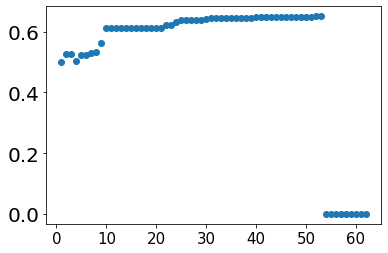

In [41]:
plt.scatter(range(1,len(names_list)+1),log_reg_BA)
index_max = np.argmax(log_reg_BA)
print("Maximizer at", index_max + 1, "covariates.")

In [42]:
#Using 53 covariates
top_names = sorted_results.iloc[0:53]['name'].values
log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)
log_reg_preds = (log_reg_mult.predict(X_test[top_names]) >= 0.5).astype(int)
log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
log_reg_recal = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[1,0])
log_reg_prec = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[0,1])
log_reg_F1 = 2 * log_reg_prec * log_reg_recal/(log_reg_prec+log_reg_recal)

To compare the accuracies of our models, we need to use some form of adjusted accuracy score, since predicting all fully paid on the 80/20 ratio of fully paid loans to defaulted loans will return 80% accuracy, despite being a meaningless prediction. We take a look at the balanced accuracy score, recall, and F1 score. Balanced accuracy score is a reweighted accuracy score that ranges from 0.5 to 1.0. Recall is the proportion of defaulted loans that we correctly predict. F1 score is a ratio that uses recall and precision to compare the predictive power of two models.

In [43]:
print('Log Reg Balanced Accuracy Score:',log_reg_BA)
print('Log Reg F1 Score:',log_reg_F1)
print('Log Reg Recall:',log_reg_recal)

Log Reg Balanced Accuracy Score: 0.5239111149107777
Log Reg F1 Score: 0.10701936376210235
Log Reg Recall: 0.05926564220403083


The scores are quite low, though this is likely due to the fact that the loan_status data is heavily skewed (80% paid, 20% default), so the predicted probabilities are all quite low. Instead of a 0.5 threshold for determining if our prediction will be fully paid or defaulted, we can select a better threshold using the receiver operating characteristic (ROC) curve.

# Probability Threshold Adjustment with ROC

<Figure size 360x216 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0.98, 'ROC Curve')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

(array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <a list of 5 Text major ticklabel objects>)

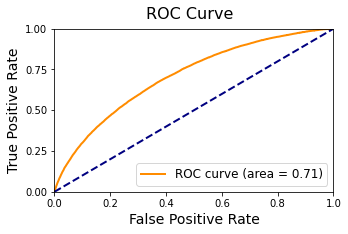

Optimal Threshold: 0.18303220407856516


In [44]:
# Compute ROC curve and ROC area for each class
plt.rcParams.update({'font.size': 12})
fpr, tpr, thresholds = roc_curve(y_valid, log_reg_mult.predict(X_valid[top_names]))
roc_auc = auc(fpr, tpr)

#Plotting the LR ROC Curve
plt.figure(figsize=(5,3))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize = 14)
plt.ylabel("True Positive Rate", fontsize = 14)
plt.suptitle("ROC Curve", fontsize=16)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc="lower right")
plt.show()

#Computing the best threshold
gmeans = tpr * (1-fpr)
id = np.argmax(gmeans)
print("Optimal Threshold:",thresholds[id])

In [45]:
#Using 53 covariates with Threshold adjustment
top_names = sorted_results.iloc[0:53]['name'].values
log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)
log_reg_preds = (log_reg_mult.predict(X_test[top_names]) >= thresholds[id]).astype(int)
log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
log_reg_recal = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[1,0])
log_reg_prec = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[0,1])
log_reg_F1 = 2 * log_reg_prec * log_reg_recal/(log_reg_prec+log_reg_recal)

In [46]:
print('Log Reg Balanced Accuracy Score:',log_reg_BA)
print('Log Reg F1 Score:',log_reg_F1)
print('Log Reg Recall:',log_reg_recal)

Log Reg Balanced Accuracy Score: 0.6513822242633702
Log Reg F1 Score: 0.4160391343018085
Log Reg Recall: 0.6717889798458518


Using the optimal threshold of 0.183, we obtain much better scores.

# XGBoost Prediction

In [47]:
from sklearn.metrics import balanced_accuracy_score
#Code for parameter fitting
accur = [0]*10
FN = [0]*10
FP = [0]*10
F1 = [0]*10
prec = [0]*10
recal = [0]*10
BA = [0]*10

# Parameter selection grid search for eta:
# Note: We used the same process for max_depth and found that 6 is optimal. 
for i in range(1,11):
    print(i)
    xgb_cl = xgb.XGBClassifier(use_label_encoder=False,booster='gbtree',verbosity=0,max_depth=6,eta=0.1 * i,gamma=0)
    model = xgb_cl.fit(X_train,y_train)
    preds = model.predict(X_valid)
    accur[i-1]=accuracy_score(y_valid, preds)
    FN[i-1] = confusion_matrix(y_valid, preds)[1,0]
    FP[i-1] = confusion_matrix(y_valid, preds)[0,1]
    prec[i-1] = confusion_matrix(y_valid, preds)[1,1]/(confusion_matrix(y_valid, preds)[1,1]+confusion_matrix(y_valid, preds)[0,1])
    recal[i-1] = confusion_matrix(y_valid, preds)[1,1]/(confusion_matrix(y_valid, preds)[1,1]+confusion_matrix(y_valid, preds)[1,0])
    F1[i-1] = 2 * prec[i-1] * recal[i-1]/(prec[i-1]+recal[i-1])
    BA[i-1] = balanced_accuracy_score(y_valid, preds)

1


/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2
3
4
5
6
7
8
9
10


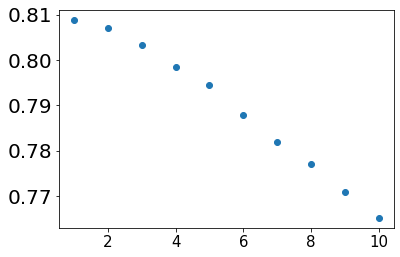

In [48]:
plt.scatter(range(1,11),accur)

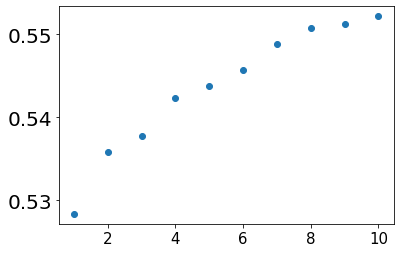

In [49]:
plt.scatter(range(1,11),BA)

In [50]:
#Reset to Full Dataset
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [51]:
#For fitting full model 
xgb_cl = xgb.XGBClassifier(use_label_encoder=False,booster='gbtree',verbosity=0,max_depth=6,eta=0.9,gamma=0)
model = xgb_cl.fit(X_train,y_train)

In [52]:
#Check Model Accuracy
xgb_preds = model.predict(X_test)
xgb_prec = confusion_matrix(y_test, xgb_preds)[1,1]/(confusion_matrix(y_test, xgb_preds)[1,1]+confusion_matrix(y_test, xgb_preds)[0,1])
xgb_recal = confusion_matrix(y_test, xgb_preds)[1,1]/(confusion_matrix(y_test, xgb_preds)[1,1]+confusion_matrix(y_test, xgb_preds)[1,0])
xgb_F1 = 2 * xgb_prec * xgb_recal/(xgb_prec+xgb_recal)
xgb_BA = balanced_accuracy_score(y_test, xgb_preds)

In [53]:
print('XGB Balanced Accuracy Score:',xgb_BA)
print('XGB F1 Score:',xgb_F1)
print('XGB Recall:',xgb_recal)

XGB Balanced Accuracy Score: 0.5498103066768298
XGB F1 Score: 0.24307924528301889
XGB Recall: 0.19273301737756715


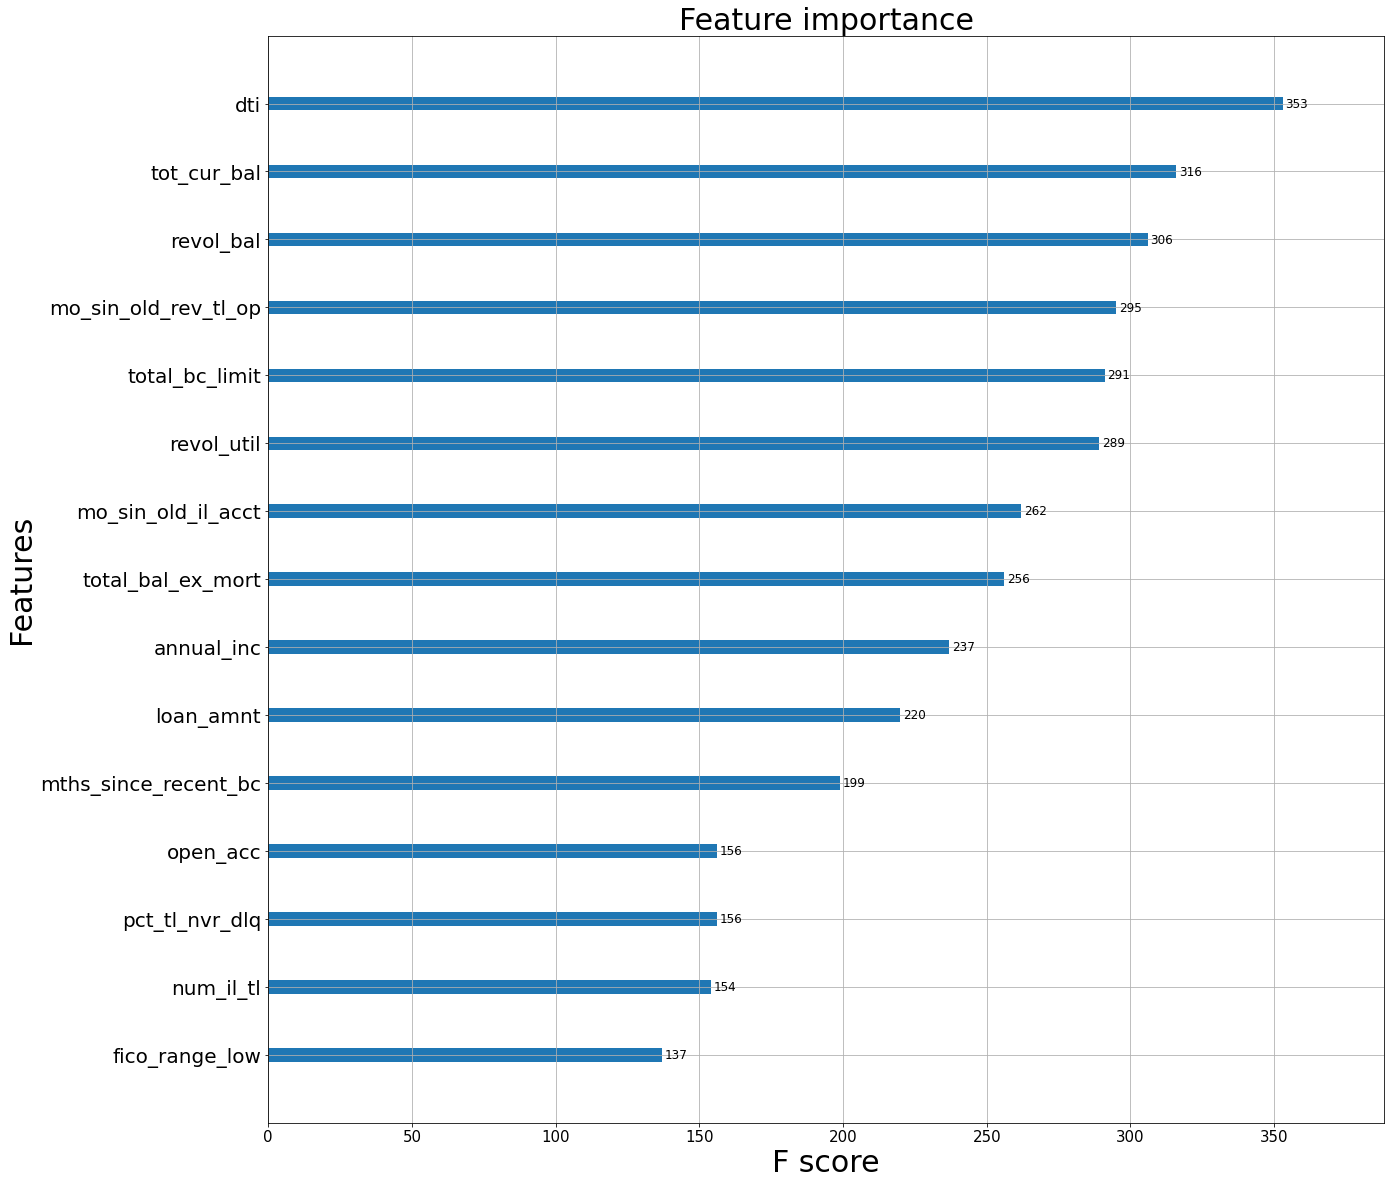

In [54]:
#Feature Importance
fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_importance(model,max_num_features=15,ax=ax)

These most significant features seem to agree with economic intuition, e.g., annual income and the loan amount are significant predictors of default probability.